In [31]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from glob import glob

# Constants
SOFT_DEG = 0.01
MEDIUM_DEG = 0.007
HARD_DEG = 0.005
BATCH_SIZE = 10000
NUM_LAPS = 58
DATA_FOLDER = "E:/fastf1_csv_data/Data/Austrailian Grand Prix/Race"

# Function to Load Offline CSV Data
def load_offline_data():
    """Loads lap data from stored CSV files."""
    all_files = glob(os.path.join(DATA_FOLDER, '*.csv'))
    df_list = []

    for file in all_files:
        df = pd.read_csv(file)
        df_list.append(df)

    return pd.concat(df_list, ignore_index=True) if df_list else pd.DataFrame()  # Merge all CSVs into one DataFrame

# Function to Prepare Data
def prepare_data(df):
    """Processes offline lap data into training features and targets."""
    df = df.dropna(subset=['LapTime'])  # Remove missing lap times
    df['LapTime'] = pd.to_timedelta(df['LapTime']).dt.total_seconds()  # Convert LapTime to seconds

    lap_times = df['LapTime'].values
    laps = np.arange(1, len(lap_times) + 1).reshape(-1, 1)  # Use lap numbers as feature

    return laps, lap_times  # X (Lap Numbers), y (Lap Times)

# Function to Build Model
def build_model():
    """Builds and compiles the ANN model."""
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(1,)),  # Lap number as input
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1)  # Output: Lap Time
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Function to Train Model in Batches
def train_model_in_batches(model, X, y, batch_size):
    """Trains the model using batch processing to optimize memory usage."""
    num_samples = len(X)
    for start in range(0, num_samples, batch_size):
        end = min(start + batch_size, num_samples)
        model.fit(X[start:end], y[start:end], epochs=150, verbose=1)  # Train on batch

# Function to Predict Lap Times
def predict_lap_times(model, degradation, initial_lap):
    """Predicts lap times over multiple laps and converts to MM:SS.mmm format."""
    lap_times = []
    lap_number = np.array([[initial_lap]])

    for _ in range(NUM_LAPS):
        lap_time = model.predict(lap_number, verbose=0)[0][0]
        lap_number[0, 0] += 1  # Increment lap number
        lap_time += degradation  # Apply degradation
        lap_times.append(lap_time)

    return lap_times

# Convert Seconds to MM:SS.mmm Format
def seconds_to_min_sec(predicted_lap_times):
    """Converts lap times from seconds to MM:SS.mmm format."""
    return [f"{int(time // 60)}:{time % 60:.3f}" for time in predicted_lap_times]

# Load Offline Data
df = load_offline_data()
if df.empty:
    print("⚠ No offline data found! Check your CSV files in the specified directory.")
else:
    # Prepare Data
    X_data, y_data = prepare_data(df)

    # Build and Train Model
    model = build_model()
    train_model_in_batches(model, X_data, y_data, BATCH_SIZE)

    # Predict Lap Times
    initial_lap = 1
    degradation = 0.002  # Adjust degradation factor
    predicted_lap_times = predict_lap_times(model, degradation, initial_lap)

    # Convert to Minutes:Seconds Format
    formatted_lap_times = seconds_to_min_sec(predicted_lap_times)

    print("\nPredicted Lap Times (MM:SS.mmm):")
    for i, lap_time in enumerate(formatted_lap_times, start=1):
        print(f"Lap {i}: {lap_time}")


Epoch 1/150


C:\Users\WIN 10\AppData\Local\Temp\ipykernel_21692\365938894.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['LapTime'] = pd.to_timedelta(df['LapTime']).dt.total_seconds()  # Convert LapTime to seconds
D:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 879us/step - loss: 23507.1465 - mae: 103.9226
Epoch 2/150
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - loss: 2269.9233 - mae: 38.5404
Epoch 3/150
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - loss: 2204.5024 - mae: 38.2833
Epoch 4/150
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step - loss: 2211.3450 - mae: 38.5209
Epoch 5/150
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - loss: 2196.2317 - mae: 38.3386
Epoch 6/150
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - loss: 2191.8582 - mae: 38.1685
Epoch 7/150
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - loss: 2148.4136 - mae: 37.2468
Epoch 8/150
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - loss: 2055.7388 - mae: 36.5620
Epoch 9/150
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - loss: 2058.7373 - mae: 36.9876
Epoch 10/150
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - loss: 2100.4600 - mae: 37.1729
Epoch 11/150
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - loss: 2105.1084 - mae: 37.6307
Epoch 12/150
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - loss: 

In [19]:
session = fastf1.get_session(2018, 'Monaco Grand Prix', 'R')

In [ ]:
session.load(telemetry= True, laps = True, weather = True)

In [ ]:
session.laps

In [25]:
monaco_R_data = session.laps
monaco_R_data.to_csv('Monaco_2018_R.csv', index=True)

In [5]:
event = fastf1.get_event(2021,'spain')
event['EventName']

'Spanish Grand Prix'

In [ ]:
schedule = fastf1.get_event_schedule(2025)
schedule

In [ ]:
session = fastf1.get_session(2024, 'Monaco', 'R')
session.load()
session.results

In [ ]:
#start live client
import asyncio
import logging
from fastf1.livetiming.client import SignalRClient


log = logging.getLogger('fastf1')
log.setLevel(logging.DEBUG)

client = SignalRClient(filename="output.txt", debug=True)
await client.async_start()

In [ ]:
#start live client
import nest_asyncio
import asyncio
from fastf1.livetiming.client import SignalRClient
import logging

nest_asyncio.apply()
log = logging.getLogger('fastf1')
log.setLevel(logging.DEBUG)

async def run_client():
    client = SignalRClient(filename = "output.txt", debug=True)
    await client.async_start()

await run_client()

In [3]:
pip install nest_asyncio


Note: you may need to restart the kernel to use updated packages.


In [1]:
import fastf1
import pandas as pd
import os
import time
from concurrent.futures import ThreadPoolExecutor

# Enable caching (Optional, speeds up repeated requests)
fastf1.Cache.enable_cache('E:\\Python codes\\cache')

# Define the range of years and events (Modify as needed)
YEARS = range(2020, 2021)  # Example: 2021 to 2023
SESSIONS = ['FP1', 'FP2', 'FP3', 'Q', 'R']  # Practice, Qualifying, Race

# Folder to store CSV files
SAVE_FOLDER = "E:/fastf1_csv_data/"
os.makedirs(SAVE_FOLDER, exist_ok=True)

def download_session_data(year, event_name, session_type):
    """Downloads lap data for a given year, event, and session."""
    try:
        print(f"\nFetching data: {year} - {event_name} - {session_type}...")

        # Request the session from FastF1
        session = fastf1.get_session(year, event_name, session_type)
        session.load(telemetry=True, laps=True, weather=True)  # Load only lap data

        # Define the CSV file path
        file_path = os.path.join(SAVE_FOLDER, f"{year}_{event_name}_{session_type}.csv")

        # Save lap data to CSV
        if not session.laps.empty:  # Ensure data is available
            session.laps.to_csv(file_path, index=False)
            print(f"✅ Saved: {file_path}")
        else:
            print(f"⚠ No lap data available for {year} - {event_name} - {session_type}")
    
    except Exception as e:
        print(f"❌ Error fetching {year} - {event_name} - {session_type}: {e}")

# Iterate through years and races
def fetch_all_sessions():
    tasks = []
    for year in YEARS:
        schedule = fastf1.get_event_schedule(year)  # Get event schedule for the year
        for _, row in schedule.iterrows():
            event_name = row['EventName']
        
            for session_type in SESSIONS:
                tasks.append((year, event_name,session_type))
    with ThreadPoolExecutor(max_workers=5) as executor:
        executor.map(lambda args: download_session_data(*args),tasks)

fetch_all_sessions()


events      WARNING 	Correcting user input 'Pre-Season Test 1' to 'Austrian Grand Prix'
events      WARNING 	Correcting user input 'Pre-Season Test 1' to 'Austrian Grand Prix'
core           INFO 	Loading data for Austrian Grand Prix - Practice 1 [v3.4.4]
events      WARNING 	Correcting user input 'Pre-Season Test 1' to 'Austrian Grand Prix'
events      WARNING 	Correcting user input 'Pre-Season Test 1' to 'Austrian Grand Prix'
core           INFO 	Loading data for Austrian Grand Prix - Practice 2 [v3.4.4]
core           INFO 	Loading data for Austrian Grand Prix - Qualifying [v3.4.4]
core           INFO 	Loading data for Austrian Grand Prix - Race [v3.4.4]
req            INFO 	No cached data found for session_info. Loading data...
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	No cached data found for session_info. Loading data...
req            INFO 	No cached data found for session_i


Fetching data: 2020 - Pre-Season Test 1 - FP1...

Fetching data: 2020 - Pre-Season Test 1 - FP2...

Fetching data: 2020 - Pre-Season Test 1 - FP3...

Fetching data: 2020 - Pre-Season Test 1 - Q...

Fetching data: 2020 - Pre-Season Test 1 - R...


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	Data has been written to cache!
req            INFO 	Data has

✅ Saved: E:/fastf1_csv_data/2020_Pre-Season Test 1_Q.csv

Fetching data: 2020 - Pre-Season Test 2 - FP1...


events      WARNING 	Correcting user input 'Pre-Season Test 2' to 'Austrian Grand Prix'
core           INFO 	Loading data for Austrian Grand Prix - Practice 1 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Driver 23: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver  5: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver 99: Lap timing integrity check failed for 1 lap(s)
req            INFO 	No cached data found for car_data. Loading data...
_api           INFO 	Fetching car data...
core        WARNING 	Driver 23: Lap timing integrity check failed for 1 lap

✅ Saved: E:/fastf1_csv_data/2020_Pre-Season Test 1_FP3.csv

Fetching data: 2020 - Pre-Season Test 2 - FP2...


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for position_data. Loading data...
_api           INFO 	Fetching position data...
req            INFO 	Using cached data for car_data
req            INFO 	No cached data found for position_data. Loading data...
_api           INFO 	Fetching position data...
_api           INFO 	Parsing position data...
_api           INFO 	Parsing position data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for position_data. Loading data...
_api           INFO 	Fetching position data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for position_data. Loading data...
_api           INFO 	Fetching position data...
_api           INFO 	Parsing position data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for weather_data. Loading data...
_api           INFO 	Fetch

✅ Saved: E:/fastf1_csv_data/2020_Pre-Season Test 1_FP2.csv

Fetching data: 2020 - Pre-Season Test 2 - FP3...


core           INFO 	Loading data for Austrian Grand Prix - Practice 3 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Data has been written to cache!
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['10', '11', '16', '18', '20', '23', '26', '3', '31', '33', '4', '44', '5', '55', '6', '63', '7', '77', '8', '99']
events      WARNING 	Correcting user input 'Pre-Season Te

✅ Saved: E:/fastf1_csv_data/2020_Pre-Season Test 2_FP2.csv

Fetching data: 2020 - Pre-Season Test 2 - Q...


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['10', '11', '16', '18', '20', '23', '26', '3', '31', '33', '4', '44', '5', '55', '6', '63', '7', '77', '8', '99']
events      WARNING 	Correcting user input 'Pre-Season Test 2' to 'Austrian Grand Prix'
core           INFO 	Loading data for Austrian Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data


✅ Saved: E:/fastf1_csv_data/2020_Pre-Season Test 2_FP3.csv

Fetching data: 2020 - Pre-Season Test 2 - R...


core           INFO 	Processing timing data...
req            INFO 	Using cached data for position_data
core        WARNING 	Driver 77: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver 16: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver  4: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver 44: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver 55: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver 11: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver 10: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver 31: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver 99: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver  5: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver 26: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver

✅ Saved: E:/fastf1_csv_data/2020_Pre-Season Test 2_Q.csv

Fetching data: 2020 - Austrian Grand Prix - FP1...


req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
_api        WARNING 	Driver 241: Position data is incomplete!
_api        WARNING 	Driver 242: Position data is incomplete!
core        WARNING 	Driver 23: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver  5: Lap timing integrity check failed for 1 lap(s)
_api        WARNING 	Driver 243: Position data is incomplete!
core        WARNING 	Driver 99: Lap timing integrity check failed for 1 lap(s)
req            INFO 	Data has been written to cache!
req            INFO 	Using cached data for car_data
req            INFO 	No cached data found for position_data. Loadi

✅ Saved: E:/fastf1_csv_data/2020_Pre-Season Test 1_R.csv

Fetching data: 2020 - Austrian Grand Prix - FP2...


req            INFO 	No cached data found for race_control_messages. Loading data...
_api           INFO 	Fetching race control messages...
req            INFO 	Data has been written to cache!
req            INFO 	Data has been written to cache!
core           INFO 	Finished loading data for 20 drivers: ['10', '11', '16', '18', '20', '23', '26', '3', '31', '33', '4', '44', '5', '55', '6', '63', '7', '77', '8', '99']
core           INFO 	Finished loading data for 20 drivers: ['10', '11', '16', '18', '20', '23', '26', '3', '31', '33', '4', '44', '5', '55', '6', '63', '7', '77', '8', '99']
core           INFO 	Loading data for Austrian Grand Prix - Practice 3 [v3.4.4]
core           INFO 	Loading data for Austrian Grand Prix - Qualifying [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for driver_info
req            INFO 	Usi

✅ Saved: E:/fastf1_csv_data/2020_Pre-Season Test 1_FP1.csv

Fetching data: 2020 - Austrian Grand Prix - FP3...
✅ Saved: E:/fastf1_csv_data/2020_Pre-Season Test 2_FP1.csv

Fetching data: 2020 - Austrian Grand Prix - Q...


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Fini

✅ Saved: E:/fastf1_csv_data/2020_Austrian Grand Prix_Q.csv

Fetching data: 2020 - Austrian Grand Prix - R...


req            INFO 	Using cached data for race_control_messages
req            INFO 	Using cached data for _extended_timing_data
core           INFO 	Finished loading data for 20 drivers: ['10', '11', '16', '18', '20', '23', '26', '3', '31', '33', '4', '44', '5', '55', '6', '63', '7', '77', '8', '99']
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['10', '11', '16', '18', '20', '23', '26', '3', '31', '33', '4', '44', '5', '55', '6', '63', '7', '77', '8', '99']
core           INFO 	Loading data for Styrian Grand Prix - Practice 1 [v3.4.4]
req            INFO 	No cached data found for session_info. Loading data...


✅ Saved: E:/fastf1_csv_data/2020_Austrian Grand Prix_FP2.csv

Fetching data: 2020 - Styrian Grand Prix - FP1...
✅ Saved: E:/fastf1_csv_data/2020_Austrian Grand Prix_FP3.csv

Fetching data: 2020 - Styrian Grand Prix - FP2...


_api           INFO 	Fetching session info data...
core           INFO 	Loading data for Styrian Grand Prix - Practice 2 [v3.4.4]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
core        WARNING 	Driver 77: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver 16: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver  4: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver 44: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver 55: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver 11: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver 10: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver 31: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver 99: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver  5: 

✅ Saved: E:/fastf1_csv_data/2020_Austrian Grand Prix_FP1.csv

Fetching data: 2020 - Styrian Grand Prix - FP3...


req            INFO 	Using cached data for weather_data
req            INFO 	No cached data found for session_info. Loading data...
core        WARNING 	No lap data for driver 99
req            INFO 	Using cached data for race_control_messages
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 63)
req            INFO 	No cached data found for driver_info. Loading data...
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 99)
_api           INFO 	Fetching driver list...
req            INFO 	No cached data found for car_data. Loading data...
req            INFO 	No cached data found for car_data. Loading data...
_api           INFO 	Fetching car data...
_api           INFO 	Fetching car data...
core           INFO 	Finished loading data for 20 drivers: ['77', '16', '4', '44', '55', '11', '10',

✅ Saved: E:/fastf1_csv_data/2020_Austrian Grand Prix_R.csv

Fetching data: 2020 - Styrian Grand Prix - Q...


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['77', '16', '4', '44', '55', '11', '10', '31', '99', '5', '6', '26', '23', '7', '63', '8', '20', '18', '3', '33']
core           INFO 	Loading data for Styrian Grand Prix - Race [v3.4.4]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...


✅ Saved: E:/fastf1_csv_data/2020_Pre-Season Test 2_R.csv

Fetching data: 2020 - Styrian Grand Prix - R...


req            INFO 	Data has been written to cache!
core        WARNING 	Failed to determine `Session.session_start_time`
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
req            INFO 	Data has been written to cache!
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for timi

❌ Error fetching 2020 - Styrian Grand Prix - FP3: The data you are trying to access has not been loaded yet. See `Session.load`

Fetching data: 2020 - Hungarian Grand Prix - FP1...


req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
_api           INFO 	Parsing position data...
req            INFO 	Data has been written to cache!
_api           INFO 	Parsing position data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for position_data. Loading data...
_api           INFO 	Fetching position data...
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req 

✅ Saved: E:/fastf1_csv_data/2020_Styrian Grand Prix_FP1.csv

Fetching data: 2020 - Hungarian Grand Prix - FP2...


core           INFO 	Loading data for Hungarian Grand Prix - Practice 2 [v3.4.4]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
_api           INFO 	Parsing car data...
core           INFO 	Loading data for Hungarian Grand Prix - Practice 3 [v3.4.4]


✅ Saved: E:/fastf1_csv_data/2020_Styrian Grand Prix_FP2.csv

Fetching data: 2020 - Hungarian Grand Prix - FP3...


req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found f

✅ Saved: E:/fastf1_csv_data/2020_Styrian Grand Prix_Q.csv

Fetching data: 2020 - Hungarian Grand Prix - Q...


req            INFO 	No cached data found for car_data. Loading data...
_api           INFO 	Fetching car data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for position_data. Loading data...
_api           INFO 	Fetching position data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
core           INFO 	Processing timing data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for car_data. Loading data...
_api           INFO 	Fetching car data...
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
_api        WARNING 	Driver 241: Position data is incomplete!
_api        WARNING 	Driver 242: Position data is incomplete!
_api     

✅ Saved: E:/fastf1_csv_data/2020_Styrian Grand Prix_R.csv

Fetching data: 2020 - Hungarian Grand Prix - R...


core           INFO 	Loading data for Hungarian Grand Prix - Race [v3.4.4]
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_info. Loading data...
req            INFO 	No cached data found for timing_app_data. Loading data...
_api           INFO 	Fetching session info data...
_api           INFO 	Fetching timing app data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
core           INFO 	Processing timing data...
_api        WARNING 	Driver  1: Car data is incomplete!
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
req            INFO 	No cached data found for car_data. Loading data...
_api           INFO 	Fetching session status data...
_api           INFO 	Fetchi

✅ Saved: E:/fastf1_csv_data/2020_Hungarian Grand Prix_FP1.csv

Fetching data: 2020 - British Grand Prix - FP1...


req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	No cached data found for car_data. Loading data...
_api           INFO 	Fetching car data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
_api        WARNING 	Driver  1: Car data is incomplete!
_api        WARNING 	Driver  2: Car data is incomplete!
_api        WARNING 	Driver  9: Car data is incomplete!
_api        WARNING 	Driver 12: Car data is incomplete!
_api        WARNING 	Driver 14: Car data is incomplete!
_api        WARNING 	Driver 15: Car data is incomplete!
_api        WARNING 	Driver 17: Car data is incomplete!
_api        WARNING 	Driver 19: Car data is incomplete!
_api        WARNING 	Driver 21: Car data is incomplete!
_api        WARNING 	Driver 22: Car data is incomplete!
_api        WARNING 	Drive

✅ Saved: E:/fastf1_csv_data/2020_Hungarian Grand Prix_FP2.csv

Fetching data: 2020 - British Grand Prix - FP2...


_api           INFO 	Parsing timing data...
core           INFO 	Loading data for British Grand Prix - Practice 2 [v3.4.4]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for timing_app_data. Loading data...
_api           INFO 	Fetching timing app data...
req            INFO 	Data has been written to cache!
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
_api           INFO 	Parsing car data...
req            INFO 	Data has been written to cache!
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 0
core        WARNING 	No lap data for driver 11
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for weather_da

✅ Saved: E:/fastf1_csv_data/2020_Hungarian Grand Prix_FP3.csv

Fetching data: 2020 - British Grand Prix - FP3...


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Parsing car data...
_api           INFO 	Fetching timing data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for timing_app_data. Loading data...


✅ Saved: E:/fastf1_csv_data/2020_Hungarian Grand Prix_Q.csv

Fetching data: 2020 - British Grand Prix - Q...


req            INFO 	Data has been written to cache!
core           INFO 	Processing timing data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	No cached data found for car_data. Loading data...
_api           INFO 	Fetching car data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
_api           INFO 	Parsing car data...
_api           INFO 	Parsing car data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for position_data. Loading data...
_api           INFO 	Fetchi

✅ Saved: E:/fastf1_csv_data/2020_British Grand Prix_FP1.csv

Fetching data: 2020 - British Grand Prix - R...


core           INFO 	Loading data for 70th Anniversary Grand Prix - Practice 1 [v3.4.4]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...


✅ Saved: E:/fastf1_csv_data/2020_Hungarian Grand Prix_R.csv

Fetching data: 2020 - 70th Anniversary Grand Prix - FP1...


req            INFO 	Data has been written to cache!
core           INFO 	Finished loading data for 20 drivers: ['10', '16', '18', '20', '23', '26', '27', '3', '31', '33', '4', '44', '5', '55', '6', '63', '7', '77', '8', '99']
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
core           INFO 	Loading data for 70th Anniversary Grand Prix - Practice 2 [v3.4.4]


✅ Saved: E:/fastf1_csv_data/2020_British Grand Prix_FP3.csv

Fetching data: 2020 - 70th Anniversary Grand Prix - FP2...


req            INFO 	No cached data found for session_info. Loading data...
req            INFO 	Data has been written to cache!
_api           INFO 	Fetching session info data...
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	Data has been written to cache!
req  

✅ Saved: E:/fastf1_csv_data/2020_British Grand Prix_FP2.csv

Fetching data: 2020 - 70th Anniversary Grand Prix - FP3...


core           INFO 	Finished loading data for 20 drivers: ['44', '77', '33', '16', '4', '18', '55', '3', '31', '5', '10', '23', '27', '26', '63', '20', '99', '7', '8', '6']
core           INFO 	Loading data for 70th Anniversary Grand Prix - Qualifying [v3.4.4]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...


✅ Saved: E:/fastf1_csv_data/2020_British Grand Prix_Q.csv

Fetching data: 2020 - 70th Anniversary Grand Prix - Q...


_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api        WARNING 	Driver  4: Ignoring late data for a previously processed lap.The data may contain errors (previous: 35; current 36)
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
_api           INFO 	Fetching driver list...
_api           INFO 	Parsing timing data...
_api        WARNING 	Driver  8: Encountered 1 timing integrity error(s) near lap(s): [15].
This might be a bug and should be reported.
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!
req            INFO 	Data has been written to cache!
req            INFO 	Data has been written to cache!
_api        WARNING 	Driver 10: Ignoring late data for a previously processed lap.The data 

✅ Saved: E:/fastf1_csv_data/2020_70th Anniversary Grand Prix_FP1.csv

Fetching data: 2020 - 70th Anniversary Grand Prix - R...


core           INFO 	Loading data for 70th Anniversary Grand Prix - Race [v3.4.4]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
_api           INFO 	Parsing position data...
_api           INFO 	Parsing position data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	No cached data found for weather_data. Loading data...
_api           INFO 	Fetching weat

✅ Saved: E:/fastf1_csv_data/2020_70th Anniversary Grand Prix_FP3.csv

Fetching data: 2020 - Spanish Grand Prix - FP1...


req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
req            INFO 	Data has been written to 

✅ Saved: E:/fastf1_csv_data/2020_70th Anniversary Grand Prix_FP2.csv

Fetching data: 2020 - Spanish Grand Prix - FP2...


req            INFO 	Data has been written to cache!
core           INFO 	Finished loading data for 20 drivers: ['77', '44', '27', '33', '3', '18', '10', '16', '23', '4', '31', '5', '55', '8', '63', '26', '20', '6', '99', '7']
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for car_data. Loading data...
core           INFO 	Processing timing data...
_api           INFO 	Fetching car data...
req            INFO 	Data has been written to cache!


✅ Saved: E:/fastf1_csv_data/2020_70th Anniversary Grand Prix_Q.csv

Fetching data: 2020 - Spanish Grand Prix - FP3...


core           INFO 	Loading data for Spanish Grand Prix - Practice 3 [v3.4.4]
req            INFO 	No cached data found for driver_info. Loading data...
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching driver list...
_api           INFO 	Fetching session info data...
core        WARNING 	No lap data for driver 63
req            INFO 	Data has been written to cache!
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	No cached data found for session_status_data. Loading data...
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 63)
_api           INFO 	Fetching session status data...
req            INFO 	No cached data found for car_data. Loading data...
_api           INFO 	Fetching car data...
_api        WARNING 	Driver 241: Position data is

✅ Saved: E:/fastf1_csv_data/2020_British Grand Prix_R.csv

Fetching data: 2020 - Spanish Grand Prix - Q...


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
_api           INFO 	Parsing car data...
_api           INFO 	Parsing timing data...
_api        WARNING 	Driver  7: Ignoring late data for a previously processed lap.The data may contain errors (previous: 9; current 10)
_api           INFO 	Parsing timing data...
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for timing_app_data. Loading data...
_api           INFO 	Fetching timing app data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for timing_app_data. Loading data...
_api           INFO 	Fetching timing app data...
_api       

✅ Saved: E:/fastf1_csv_data/2020_70th Anniversary Grand Prix_R.csv

Fetching data: 2020 - Spanish Grand Prix - R...
✅ Saved: E:/fastf1_csv_data/2020_Spanish Grand Prix_FP3.csv

Fetching data: 2020 - Belgian Grand Prix - FP1...


req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
core           INFO 	Finished loading data for 21 drivers: ['10', '11', '16', '18', '20', '23', '26', '3', '31', '33', '4', '40', '44', '5', '55', '6', '63', '7', '77', '8', '99']
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
core           INFO 	Loading data for Belgian Grand Prix - Practice 2 [v3.4.4]


✅ Saved: E:/fastf1_csv_data/2020_Spanish Grand Prix_FP1.csv

Fetching data: 2020 - Belgian Grand Prix - FP2...


req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...

✅ Saved: E:/fastf1_csv_data/2020_Spanish Grand Prix_Q.csv

Fetching data: 2020 - Belgian Grand Prix - FP3...


core           INFO 	Loading data for Belgian Grand Prix - Practice 3 [v3.4.4]
req            INFO 	No cached data found for _extended_timing_data. Loading data...
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Fetching session info data...
_api        WARNING 	Driver 40: Position data is incomplete!
_api        WARNING 	Driver 63: Position data is incomplete!
req            INFO 	Data has been written to cache!
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	No cached data found for weather_data. Loading data...
_api           INFO 	Fetching weather data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
_api 

✅ Saved: E:/fastf1_csv_data/2020_Spanish Grand Prix_FP2.csv

Fetching data: 2020 - Belgian Grand Prix - Q...


core           INFO 	Loading data for Belgian Grand Prix - Qualifying [v3.4.4]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for timing_app_data. Loading data...
_api           INFO 	Fetching timing app data...
req            INFO 	No cached data found for car_data. Loading data...
_api           INFO 	Fetching car data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for timing_app_data. Loading data...
_api           INFO 	Fetching timing app data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
core           INFO 	Processing timing data...
req            INFO 	Data has been written to

✅ Saved: E:/fastf1_csv_data/2020_Belgian Grand Prix_FP3.csv

Fetching data: 2020 - Belgian Grand Prix - R...


req            INFO 	No cached data found for weather_data. Loading data...
_api           INFO 	Fetching weather data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
_api           INFO 	Parsing position data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for race_control_messages. Loading data...
_api           INFO 	Fetching race control messages...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
core           INFO 	Finished loading data for 20 drivers: ['10', '11', '16', '18', '20', '23', '26', '3', '31', '33', '4', '44', '5', '55', '6', '63', '7', '77', '8', '99']
core           INFO 	Loading data for Italian Gran

✅ Saved: E:/fastf1_csv_data/2020_Belgian Grand Prix_FP1.csv

Fetching data: 2020 - Italian Grand Prix - FP1...


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	No cached d

✅ Saved: E:/fastf1_csv_data/2020_Belgian Grand Prix_Q.csv

Fetching data: 2020 - Italian Grand Prix - FP2...


core           INFO 	Loading data for Italian Grand Prix - Practice 2 [v3.4.4]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
_api        WARNING 	Driver 26: Ignoring late data for a previously processed lap.The data may contain errors (previous: 40; current 41)
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for timing_app_data. Loading data...
_api           INFO 	Fetching timing app data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
req            INFO 	No cached data found for timing_app_data. Loading

✅ Saved: E:/fastf1_csv_data/2020_Belgian Grand Prix_FP2.csv

Fetching data: 2020 - Italian Grand Prix - FP3...


core           INFO 	Loading data for Italian Grand Prix - Practice 3 [v3.4.4]
_api           INFO 	Parsing timing data...
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for timing_app_data. Loading data...
_api           INFO 	Fetching timing app data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
core           INFO 	Processing timing data...
_api           INFO 	Parsing car data...
req          

✅ Saved: E:/fastf1_csv_data/2020_Spanish Grand Prix_R.csv

Fetching data: 2020 - Italian Grand Prix - Q...


req            INFO 	No cached data found for position_data. Loading data...
_api           INFO 	Fetching position data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
req            INFO 	No cached data found for timing_app_data. Loading data...
_api           INFO 	Fetching driver list...
_api           INFO 	Fetching timing app data...
req            INFO 	Data has been written to cache!
req            INFO 	Data has been written to cache!
core           INFO 	Processing timing data...
req            INFO 	No cached data found for car_data. Loading data...
_api           INFO 	Fetching car data...
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	N

✅ Saved: E:/fastf1_csv_data/2020_Italian Grand Prix_FP1.csv

Fetching data: 2020 - Italian Grand Prix - R...


req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for position_data. Loading data...
_api           INFO 	F

✅ Saved: E:/fastf1_csv_data/2020_Belgian Grand Prix_R.csv

Fetching data: 2020 - Tuscan Grand Prix - FP1...


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for weather_data. Loading data...
_api           INFO 	Fetching weather data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for timing_app_data. Loading data...
_api           INFO 	Fetching timing app data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for race_control_messages. Loading data...
_api           INFO 	Fetching race control messages...
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
core           INFO 	Processing timing data..

✅ Saved: E:/fastf1_csv_data/2020_Italian Grand Prix_FP3.csv

Fetching data: 2020 - Tuscan Grand Prix - FP2...


req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for car_data. Loading data...
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching car data...
_api           INFO 	Fetching session status data...
req            INFO 	No cached data found for weather_data. Loading data...
_api           INFO 	Fetching weather data...
req            INFO 	Data has been writ

✅ Saved: E:/fastf1_csv_data/2020_Italian Grand Prix_FP2.csv

Fetching data: 2020 - Tuscan Grand Prix - FP3...


req            INFO 	No cached data found for car_data. Loading data...
_api           INFO 	Fetching car data...
req            INFO 	Data has been written to cache!
_api           INFO 	Parsing car data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	No cached data found for weather_data. Loading data...
_api           INFO 	Fetching weather data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for race_control_messages. Loading data...
req            INFO 	Data has been written to cache!
_api           INFO 	Fetching race control messages...
req            INF

✅ Saved: E:/fastf1_csv_data/2020_Italian Grand Prix_Q.csv

Fetching data: 2020 - Tuscan Grand Prix - Q...


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
req            INFO 	Data has been written to cache!
core           INFO 	Processing timing data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
_api           INFO 	Parsing timing data...
core        WARNING 	Driver 99: Lap timing integrity check failed for 1 lap(s)
req            INFO 	No cached data found for car_data. Loading data...
_api           INFO 	Fetching car data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
req            INFO 	No cached data found for timing_app_data. Loading data...
_api           INFO 	Fetching session s

✅ Saved: E:/fastf1_csv_data/2020_Italian Grand Prix_R.csv

Fetching data: 2020 - Tuscan Grand Prix - R...


req            INFO 	No cached data found for race_control_messages. Loading data...
_api           INFO 	Fetching race control messages...
req            INFO 	No cached data found for weather_data. Loading data...
_api           INFO 	Fetching weather data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '33', '23', '16', '11', '18', '3', '55', '31', '4', '26', '7', '5', '8', '10', '99', '63', '6', '20']
req            INFO 	Data has been written to cache!
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for race_control_messages. Loading data...


❌ Error fetching 2020 - Tuscan Grand Prix - Q: The data you are trying to access has not been loaded yet. See `Session.load`

Fetching data: 2020 - Russian Grand Prix - FP1...


core           INFO 	Loading data for Russian Grand Prix - Practice 1 [v3.4.4]
req            INFO 	No cached data found for race_control_messages. Loading data...
req            INFO 	Data has been written to cache!
_api           INFO 	Fetching race control messages...
_api           INFO 	Fetching race control messages...
req            INFO 	No cached data found for session_info. Loading data...
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session info data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
core           INFO 	Finished loading data for 20 drivers: ['10', '11', '16', '18', '20', '23', '26', '3', '31', '33', '4', '44', '5', '55', '6', '63', '7', '77', '8', '99']
req            INFO 	Data has been written to cache!
core           INFO 	Finished loading data for 20 drivers: ['10', '11', '16', '18', '20', '23', '26', '3', '31', '33', '4', '44', 

✅ Saved: E:/fastf1_csv_data/2020_Tuscan Grand Prix_FP3.csv

Fetching data: 2020 - Russian Grand Prix - FP2...
✅ Saved: E:/fastf1_csv_data/2020_Tuscan Grand Prix_FP1.csv

Fetching data: 2020 - Russian Grand Prix - FP3...


_api           INFO 	Fetching driver list...
core           INFO 	Loading data for Russian Grand Prix - Practice 3 [v3.4.4]
core           INFO 	Loading data for Russian Grand Prix - Practice 2 [v3.4.4]
req            INFO 	No cached data found for session_info. Loading data...
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
req            INFO 	Data has been written to cache!
req            INFO 	Data has been written to cache!
_api           INFO 	Fetching driver list...
req            INFO 	No ca

✅ Saved: E:/fastf1_csv_data/2020_Tuscan Grand Prix_FP2.csv

Fetching data: 2020 - Russian Grand Prix - Q...


core        WARNING 	Failed to load extended driver information!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
logger      WARNING 	Failed to load session status data!
logger      WARNING 	Failed to load result data from Ergast!
req            INFO 	No cached data found for track_status_data. Loading data...
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
_api           INFO 	Fetching track status data...
core        WARNING 	Failed to load driver list and session results!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
logger      WARNING 	Failed to load track status data!
logger      WARNING 	Failed to load sess

❌ Error fetching 2020 - Russian Grand Prix - FP1: The data you are trying to access has not been loaded yet. See `Session.load`

Fetching data: 2020 - Russian Grand Prix - R...


logger      WARNING 	Failed to load race control messages!
logger      WARNING 	Failed to load weather data!
logger      WARNING 	Failed to load race control messages!
logger      WARNING 	Failed to load session info data!
core           INFO 	Finished loading data for 20 drivers: ['10', '11', '16', '18', '20', '23', '26', '3', '31', '33', '4', '44', '5', '55', '6', '63', '7', '77', '8', '99']
req            INFO 	No cached data found for race_control_messages. Loading data...
core           INFO 	Finished loading data for 0 drivers: []
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching race control messages...
core           INFO 	Loading data for Eifel Grand Prix - Practice 1 [v3.4.4]
_api           INFO 	Fetching driver list...
core           INFO 	Loading data for Eifel Grand Prix - Practice 2 [v3.4.4]
req            INFO 	No cached data found for session_info. Loading data...
req            INFO 	No cached data found for sessio

❌ Error fetching 2020 - Russian Grand Prix - FP2: The data you are trying to access has not been loaded yet. See `Session.load`

Fetching data: 2020 - Eifel Grand Prix - FP1...
❌ Error fetching 2020 - Russian Grand Prix - Q: The data you are trying to access has not been loaded yet. See `Session.load`

Fetching data: 2020 - Eifel Grand Prix - FP2...


logger      WARNING 	Failed to load race control messages!
_api           INFO 	Parsing timing data...
core           INFO 	Finished loading data for 20 drivers: ['10', '11', '16', '18', '20', '23', '26', '3', '31', '33', '4', '44', '5', '55', '6', '63', '7', '77', '8', '99']
core        WARNING 	Failed to load extended driver information!
logger      WARNING 	Failed to load session info data!
logger      WARNING 	Failed to load session info data!


❌ Error fetching 2020 - Russian Grand Prix - FP3: The data you are trying to access has not been loaded yet. See `Session.load`

Fetching data: 2020 - Eifel Grand Prix - FP3...


core           INFO 	Loading data for Eifel Grand Prix - Practice 3 [v3.4.4]
req            INFO 	No cached data found for session_status_data. Loading data...
req            INFO 	No cached data found for driver_info. Loading data...
req            INFO 	No cached data found for driver_info. Loading data...
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session status data...
_api           INFO 	Fetching driver list...
_api           INFO 	Fetching driver list...
_api           INFO 	Fetching session info data...
logger      WARNING 	Failed to load session status data!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for timing_app_data. Loading data...
_api           INFO 	Fetching timing app data...
core        WARNING 	Failed to load extended driver informati

❌ Error fetching 2020 - Tuscan Grand Prix - R: The data you are trying to access has not been loaded yet. See `Session.load`

Fetching data: 2020 - Eifel Grand Prix - Q...


logger      WARNING 	Failed to load telemetry data!
logger      WARNING 	Failed to load telemetry data!
logger      WARNING 	Failed to load race control messages!
logger      WARNING 	Failed to load session info data!
logger      WARNING 	Failed to load weather data!
req            INFO 	No cached data found for weather_data. Loading data...
req            INFO 	No cached data found for weather_data. Loading data...
core           INFO 	Finished loading data for 20 drivers: ['77', '33', '44', '11', '3', '16', '31', '26', '10', '23', '99', '20', '5', '7', '4', '6', '8', '63', '55', '18']
req            INFO 	No cached data found for driver_info. Loading data...
req            INFO 	No cached data found for race_control_messages. Loading data...
_api           INFO 	Fetching weather data...
_api           INFO 	Fetching weather data...
_api           INFO 	Fetching driver list...
core           INFO 	Loading data for Eifel Grand Prix - Race [v3.4.4]
_api           INFO 	Fetching race con

❌ Error fetching 2020 - Russian Grand Prix - R: The data you are trying to access has not been loaded yet. See `Session.load`

Fetching data: 2020 - Eifel Grand Prix - R...


logger      WARNING 	Failed to load race control messages!
logger      WARNING 	Failed to load session info data!
logger      WARNING 	Failed to load weather data!
logger      WARNING 	Failed to load weather data!
core        WARNING 	Failed to load extended driver information!
core           INFO 	Finished loading data for 0 drivers: []
req            INFO 	No cached data found for driver_info. Loading data...
req            INFO 	No cached data found for race_control_messages. Loading data...
req            INFO 	No cached data found for race_control_messages. Loading data...
_api           INFO 	Fetching driver list...
core           INFO 	Loading data for Portuguese Grand Prix - Practice 1 [v3.4.4]
_api           INFO 	Fetching race control messages...
_api           INFO 	Fetching race control messages...
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...


❌ Error fetching 2020 - Eifel Grand Prix - FP2: The data you are trying to access has not been loaded yet. See `Session.load`

Fetching data: 2020 - Portuguese Grand Prix - FP1...


logger      WARNING 	Failed to load result data from Ergast!
logger      WARNING 	Failed to load race control messages!
logger      WARNING 	Failed to load race control messages!
logger      WARNING 	Failed to load session info data!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
core        WARNING 	Failed to load extended driver information!
core           INFO 	Finished loading data for 0 drivers: []
core           INFO 	Finished loading data for 0 drivers: []
req            INFO 	No cached data found for driver_info. Loading data...
core        WARNING 	Failed to load driver list and session results!
core           INFO 	Loading data for Portuguese Grand Prix - Practice 2 [v3.4.4]
_api           INFO 	Fetching driver list...
core           INFO 	Loading data for Portuguese Grand Prix - Practice 3 [v3.4.4]
req            INFO 	No cached data found for session_status_data. Loading data...
req            INFO 	No cached

❌ Error fetching 2020 - Eifel Grand Prix - FP3: The data you are trying to access has not been loaded yet. See `Session.load`

Fetching data: 2020 - Portuguese Grand Prix - FP2...
❌ Error fetching 2020 - Eifel Grand Prix - FP1: The data you are trying to access has not been loaded yet. See `Session.load`

Fetching data: 2020 - Portuguese Grand Prix - FP3...


logger      WARNING 	Failed to load result data from Ergast!
logger      WARNING 	Failed to load session status data!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
core        WARNING 	Failed to load extended driver information!
logger      WARNING 	Failed to load session info data!
logger      WARNING 	Failed to load session info data!
req            INFO 	No cached data found for track_status_data. Loading data...
core        WARNING 	Failed to load driver list and session results!
req            INFO 	No cached data found for driver_info. Loading data...
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching track status data...
_api           INFO 	Fetching driver list...
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching driver list...
_api           INFO 	Fetching session status data...
logger      WARNI

❌ Error fetching 2020 - Eifel Grand Prix - Q: The data you are trying to access has not been loaded yet. See `Session.load`

Fetching data: 2020 - Portuguese Grand Prix - Q...


logger      WARNING 	Failed to load telemetry data!
logger      WARNING 	Failed to load telemetry data!
logger      WARNING 	Failed to load telemetry data!
logger      WARNING 	Failed to load weather data!
logger      WARNING 	Failed to load session info data!
req            INFO 	No cached data found for weather_data. Loading data...
req            INFO 	No cached data found for weather_data. Loading data...
req            INFO 	No cached data found for weather_data. Loading data...
req            INFO 	No cached data found for race_control_messages. Loading data...
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching weather data...
_api           INFO 	Fetching weather data...
_api           INFO 	Fetching weather data...
_api           INFO 	Fetching race control messages...
_api           INFO 	Fetching driver list...
logger      WARNING 	Failed to load race control messages!
logger      WARNING 	Failed to load weather data!
core

❌ Error fetching 2020 - Portuguese Grand Prix - FP1: The data you are trying to access has not been loaded yet. See `Session.load`

Fetching data: 2020 - Portuguese Grand Prix - R...


logger      WARNING 	Failed to load session info data!
logger      WARNING 	Failed to load race control messages!
logger      WARNING 	Failed to load race control messages!
logger      WARNING 	Failed to load race control messages!
logger      WARNING 	Failed to load result data from Ergast!
req            INFO 	No cached data found for driver_info. Loading data...
core           INFO 	Finished loading data for 0 drivers: []
core           INFO 	Finished loading data for 0 drivers: []
core           INFO 	Finished loading data for 0 drivers: []
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
_api           INFO 	Fetching driver list...
core           INFO 	Loading data for Emilia Romagna Grand Prix - Practice 1 [v3.4.4]
core        WARNING 	Failed to load driver list and session results!
core           INFO 	Loading data for Emilia Romagna Grand Prix - Qualifying [v3.4.4]
req            INFO 	No cached data found for sess

❌ Error fetching 2020 - Portuguese Grand Prix - FP2: The data you are trying to access has not been loaded yet. See `Session.load`

Fetching data: 2020 - Emilia Romagna Grand Prix - FP1...
❌ Error fetching 2020 - Portuguese Grand Prix - FP3: The data you are trying to access has not been loaded yet. See `Session.load`

Fetching data: 2020 - Emilia Romagna Grand Prix - FP2...
❌ Error fetching 2020 - Eifel Grand Prix - R: The data you are trying to access has not been loaded yet. See `Session.load`

Fetching data: 2020 - Emilia Romagna Grand Prix - FP3...
❌ Error fetching 2020 - Emilia Romagna Grand Prix - FP2: Session type 'FP2' does not exist for this event

Fetching data: 2020 - Emilia Romagna Grand Prix - Q...
❌ Error fetching 2020 - Emilia Romagna Grand Prix - FP3: Session type 'FP3' does not exist for this event

Fetching data: 2020 - Emilia Romagna Grand Prix - R...


core        WARNING 	Failed to load extended driver information!
logger      WARNING 	Failed to load session info data!
logger      WARNING 	Failed to load session status data!
logger      WARNING 	Failed to load session info data!
logger      WARNING 	Failed to load session info data!
req            INFO 	No cached data found for driver_info. Loading data...
req            INFO 	No cached data found for track_status_data. Loading data...
req            INFO 	No cached data found for driver_info. Loading data...
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
_api           INFO 	Fetching track status data...
_api           INFO 	Fetching driver list...
_api           INFO 	Fetching driver list...
core        WARNING 	Failed to load extended driver information!
core        WARNING 	Failed to load extended driver information!
logger      WARNING 	Failed to load track status data!
logger      WARNING 	Failed to load 

❌ Error fetching 2020 - Portuguese Grand Prix - Q: The data you are trying to access has not been loaded yet. See `Session.load`

Fetching data: 2020 - Turkish Grand Prix - FP1...


logger      WARNING 	Failed to load telemetry data!
logger      WARNING 	Failed to add first lap time from Ergast!
logger      WARNING 	Failed to load track status data!
logger      WARNING 	Failed to load telemetry data!
logger      WARNING 	Failed to load session info data!
req            INFO 	No cached data found for weather_data. Loading data...
req            INFO 	No cached data found for car_data. Loading data...
req            INFO 	No cached data found for _extended_timing_data. Loading data...
req            INFO 	No cached data found for weather_data. Loading data...
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching weather data...
_api           INFO 	Fetching car data...
_api           INFO 	Fetching timing data...
_api           INFO 	Fetching weather data...
_api           INFO 	Fetching driver list...
logger      WARNING 	Failed to load weather data!
core        WARNING 	Failed to load extended driver information!


❌ Error fetching 2020 - Emilia Romagna Grand Prix - Q: The data you are trying to access has not been loaded yet. See `Session.load`

Fetching data: 2020 - Turkish Grand Prix - FP2...
❌ Error fetching 2020 - Emilia Romagna Grand Prix - FP1: The data you are trying to access has not been loaded yet. See `Session.load`

Fetching data: 2020 - Turkish Grand Prix - FP3...


logger      WARNING 	Failed to add first lap time from Ergast!
req            INFO 	No cached data found for car_data. Loading data...
logger      WARNING 	Failed to load session status data!
logger      WARNING 	Failed to load race control messages!
logger      WARNING 	Failed to load session info data!
logger      WARNING 	Failed to load session info data!
_api           INFO 	Fetching car data...
req            INFO 	No cached data found for track_status_data. Loading data...
core           INFO 	Finished loading data for 0 drivers: []
req            INFO 	No cached data found for driver_info. Loading data...
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching track status data...
_api           INFO 	Fetching driver list...
_api           INFO 	Fetching driver list...
core           INFO 	Loading data for Turkish Grand Prix - Qualifying [v3.4.4]
req            INFO 	No cached data found for session_info. Loading data...
_api     

❌ Error fetching 2020 - Portuguese Grand Prix - R: The data you are trying to access has not been loaded yet. See `Session.load`

Fetching data: 2020 - Turkish Grand Prix - Q...


core        WARNING 	Failed to load extended driver information!
core        WARNING 	Failed to load extended driver information!
logger      WARNING 	Failed to load track status data!
logger      WARNING 	Failed to load session info data!
logger      WARNING 	Failed to load telemetry data!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
req            INFO 	No cached data found for driver_info. Loading data...
req            INFO 	No cached data found for weather_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Fetching driver list...
_api           INFO 	Fetching weather data...
logger      WARNING 	Failed to load weather data!
core        WARNING 	Failed to load extended driver information!
logger      WARNING 	Failed to load result data from Ergast!
logger      WARNING 	Failed to load timing data!
req            INFO 	No cached data found for race_control_messages. Loading data...
core        WARNING 	No re

❌ Error fetching 2020 - Emilia Romagna Grand Prix - R: The data you are trying to access has not been loaded yet. See `Session.load`

Fetching data: 2020 - Turkish Grand Prix - R...


logger      WARNING 	Failed to load track status data!
logger      WARNING 	Failed to load session info data!
logger      WARNING 	Failed to load session status data!
logger      WARNING 	Failed to load session status data!
logger      WARNING 	Failed to load weather data!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
req            INFO 	No cached data found for driver_info. Loading data...
req            INFO 	No cached data found for track_status_data. Loading data...
req            INFO 	No cached data found for track_status_data. Loading data...
req            INFO 	No cached data found for race_control_messages. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Fetching driver list...
_api           INFO 	Fetching track status data...
_api           INFO 	Fetching track status data...
_api           INFO 	Fetching race control messages...
core        WARNING 	Failed to load extended driver information!
logger 

❌ Error fetching 2020 - Turkish Grand Prix - FP1: The data you are trying to access has not been loaded yet. See `Session.load`

Fetching data: 2020 - Bahrain Grand Prix - FP1...


logger      WARNING 	Failed to load timing data!
logger      WARNING 	Failed to load timing data!
logger      WARNING 	Failed to load telemetry data!
logger      WARNING 	Failed to load result data from Ergast!
logger      WARNING 	Failed to load session info data!
req            INFO 	No cached data found for car_data. Loading data...
req            INFO 	No cached data found for car_data. Loading data...
req            INFO 	No cached data found for weather_data. Loading data...
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching car data...
_api           INFO 	Fetching car data...
_api           INFO 	Fetching weather data...
core        WARNING 	Failed to load driver list and session results!
_api           INFO 	Fetching driver list...
req            INFO 	No cached data found for session_status_data. Loading data...

❌ Error fetching 2020 - Turkish Grand Prix - FP3: The data you are trying to access has not been loaded yet. See `Session.load`

Fetching data: 2020 - Bahrain Grand Prix - FP2...


logger      WARNING 	Failed to load session info data!
logger      WARNING 	Failed to load session status data!
logger      WARNING 	Failed to load race control messages!
logger      WARNING 	Failed to load track status data!
logger      WARNING 	Failed to load race control messages!
req            INFO 	No cached data found for driver_info. Loading data...
req            INFO 	No cached data found for track_status_data. Loading data...
core           INFO 	Finished loading data for 0 drivers: []
req            INFO 	No cached data found for _extended_timing_data. Loading data...
core           INFO 	Finished loading data for 0 drivers: []
_api           INFO 	Fetching driver list...
_api           INFO 	Fetching track status data...
_api           INFO 	Fetching timing data...
events      WARNING 	Correcting user input 'Bahrain Grand Prix' to 'Bahrain Grand Prix'
events      WARNING 	Correcting user input 'Bahrain Grand Prix' to 'Bahrain Grand Prix'
core           INFO 	Loading data f

❌ Error fetching 2020 - Turkish Grand Prix - Q: The data you are trying to access has not been loaded yet. See `Session.load`

Fetching data: 2020 - Bahrain Grand Prix - FP3...
❌ Error fetching 2020 - Turkish Grand Prix - FP2: The data you are trying to access has not been loaded yet. See `Session.load`

Fetching data: 2020 - Bahrain Grand Prix - Q...


logger      WARNING 	Failed to load session info data!
logger      WARNING 	Failed to load session info data!
logger      WARNING 	Failed to load timing data!
logger      WARNING 	Failed to load track status data!
core        WARNING 	Failed to load extended driver information!
req            INFO 	No cached data found for driver_info. Loading data...
req            INFO 	No cached data found for driver_info. Loading data...
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching driver list...
_api           INFO 	Fetching driver list...
_api           INFO 	Fetching timing data...
logger      WARNING 	Failed to add first lap time from Ergast!
logger      WARNING 	Failed to load timing data!
core        WARNING 	Failed to load extended driver information!
core        WARNING 	Failed to load extended driver information!
req            INFO 	No cached data found for car_data. Loading data...
req            INFO 	No cached data f

❌ Error fetching 2020 - Turkish Grand Prix - R: The data you are trying to access has not been loaded yet. See `Session.load`

Fetching data: 2020 - Bahrain Grand Prix - R...
❌ Error fetching 2020 - Bahrain Grand Prix - FP1: The data you are trying to access has not been loaded yet. See `Session.load`

Fetching data: 2020 - Sakhir Grand Prix - FP1...


logger      WARNING 	Failed to load track status data!
logger      WARNING 	Failed to load session info data!
logger      WARNING 	Failed to load timing data!
logger      WARNING 	Failed to load schedule from FastF1 backend!
logger      WARNING 	Failed to load timing data!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
req            INFO 	No cached data found for driver_info. Loading data...
req            INFO 	No cached data found for car_data. Loading data...
req            INFO 	No cached data found for season_schedule. Loading data...
req            INFO 	No cached data found for car_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Fetching driver list...
_api           INFO 	Fetching car data...
_api           INFO 	Fetching season schedule...
_api           INFO 	Fetching car data...
logger      WARNING 	Failed to load timing data!
logger      WARNING 	Failed to load telemetry data!
logger      WARNING

❌ Error fetching 2020 - Sakhir Grand Prix - FP1: Failed to load any schedule data.

Fetching data: 2020 - Sakhir Grand Prix - FP2...
❌ Error fetching 2020 - Bahrain Grand Prix - FP2: The data you are trying to access has not been loaded yet. See `Session.load`

Fetching data: 2020 - Sakhir Grand Prix - FP3...
❌ Error fetching 2020 - Bahrain Grand Prix - Q: The data you are trying to access has not been loaded yet. See `Session.load`

Fetching data: 2020 - Sakhir Grand Prix - Q...


logger      WARNING 	Failed to load race control messages!
logger      WARNING 	Failed to load session info data!
logger      WARNING 	Failed to load session info data!
logger      WARNING 	Failed to load total lap count!
logger      WARNING 	Failed to load session info data!
core           INFO 	Finished loading data for 0 drivers: []
req            INFO 	No cached data found for driver_info. Loading data...
req            INFO 	No cached data found for driver_info. Loading data...
req            INFO 	No cached data found for track_status_data. Loading data...
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
_api           INFO 	Fetching driver list...
events      WARNING 	Correcting user input 'Sakhir Grand Prix' to 'Sakhir Grand Prix'
_api           INFO 	Fetching track status data...
_api           INFO 	Fetching driver list...
core           INFO 	Loading data for Sakhir Grand Prix - Race [v3.4.4]
req         

❌ Error fetching 2020 - Bahrain Grand Prix - FP3: The data you are trying to access has not been loaded yet. See `Session.load`

Fetching data: 2020 - Sakhir Grand Prix - R...


logger      WARNING 	Failed to load track status data!
core        WARNING 	Failed to load extended driver information!
logger      WARNING 	Failed to load session info data!
core        WARNING 	Failed to load extended driver information!
core        WARNING 	Failed to load extended driver information!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Fetching driver list...
logger      WARNING 	Failed to load timing data!
core        WARNING 	Failed to load extended driver information!
logger      WARNING 	Failed to load result data from Ergast!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
core        WARNING 	Failed to load driver list and session results!
req            INFO 	No cached data found for session_status_data. Loading data...
_api 

❌ Error fetching 2020 - Bahrain Grand Prix - R: The data you are trying to access has not been loaded yet. See `Session.load`

Fetching data: 2020 - Abu Dhabi Grand Prix - FP1...


logger      WARNING 	Failed to load telemetry data!
req            INFO 	No cached data found for weather_data. Loading data...
logger      WARNING 	Failed to load telemetry data!
logger      WARNING 	Failed to load weather data!
logger      WARNING 	Failed to load track status data!
logger      WARNING 	Failed to load session info data!
_api           INFO 	Fetching weather data...
req            INFO 	No cached data found for weather_data. Loading data...
req            INFO 	No cached data found for race_control_messages. Loading data...
req            INFO 	No cached data found for _extended_timing_data. Loading data...
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching weather data...
_api           INFO 	Fetching race control messages...
_api           INFO 	Fetching timing data...
_api           INFO 	Fetching driver list...
logger      WARNING 	Failed to load timing data!
core        WARNING 	Failed to load extended driver i

❌ Error fetching 2020 - Sakhir Grand Prix - FP3: The data you are trying to access has not been loaded yet. See `Session.load`

Fetching data: 2020 - Abu Dhabi Grand Prix - FP2...


logger      WARNING 	Failed to load session info data!
logger      WARNING 	Failed to add first lap time from Ergast!
logger      WARNING 	Failed to load race control messages!
logger      WARNING 	Failed to load race control messages!
req            INFO 	No cached data found for driver_info. Loading data...
req            INFO 	No cached data found for car_data. Loading data...
core           INFO 	Finished loading data for 0 drivers: []
core           INFO 	Finished loading data for 0 drivers: []
_api           INFO 	Fetching driver list...
_api           INFO 	Fetching car data...
core           INFO 	Loading data for Abu Dhabi Grand Prix - Qualifying [v3.4.4]
core           INFO 	Loading data for Abu Dhabi Grand Prix - Practice 3 [v3.4.4]
req            INFO 	No cached data found for session_info. Loading data...
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
_api           INFO 	Fetching session info 

❌ Error fetching 2020 - Sakhir Grand Prix - FP2: The data you are trying to access has not been loaded yet. See `Session.load`

Fetching data: 2020 - Abu Dhabi Grand Prix - FP3...
❌ Error fetching 2020 - Sakhir Grand Prix - Q: The data you are trying to access has not been loaded yet. See `Session.load`

Fetching data: 2020 - Abu Dhabi Grand Prix - Q...


logger      WARNING 	Failed to load result data from Ergast!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
logger      WARNING 	Failed to load session info data!
core        WARNING 	Failed to load driver list and session results!
logger      WARNING 	Failed to load telemetry data!
core        WARNING 	Failed to load extended driver information!
logger      WARNING 	Failed to load session info data!
req            INFO 	No cached data found for driver_info. Loading data...
req            INFO 	No cached data found for session_status_data. Loading data...
req            INFO 	No cached data found for weather_data. Loading data...
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
_api           INFO 	Fetching session status data...
_api           INFO 	Fetching weather data...
_api           INFO 	Fetching driver list...
core        WARNING 	Failed to l

❌ Error fetching 2020 - Sakhir Grand Prix - R: The data you are trying to access has not been loaded yet. See `Session.load`

Fetching data: 2020 - Abu Dhabi Grand Prix - R...


logger      WARNING 	Failed to load session info data!
logger      WARNING 	Failed to load session status data!
logger      WARNING 	Failed to load session status data!
logger      WARNING 	Failed to load timing data!
logger      WARNING 	Failed to load track status data!
req            INFO 	No cached data found for driver_info. Loading data...
req            INFO 	No cached data found for track_status_data. Loading data...
req            INFO 	No cached data found for track_status_data. Loading data...
req            INFO 	No cached data found for car_data. Loading data...
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching driver list...
_api           INFO 	Fetching track status data...
_api           INFO 	Fetching track status data...
_api           INFO 	Fetching car data...
_api           INFO 	Fetching timing data...
logger      WARNING 	Failed to load timing data!
logger      WARNING 	Failed to load track status d

❌ Error fetching 2020 - Abu Dhabi Grand Prix - FP1: The data you are trying to access has not been loaded yet. See `Session.load`


logger      WARNING 	Failed to load total lap count!
logger      WARNING 	Failed to load weather data!
logger      WARNING 	Failed to load race control messages!
logger      WARNING 	Failed to load weather data!
req            INFO 	No cached data found for track_status_data. Loading data...
core           INFO 	Finished loading data for 0 drivers: []
req            INFO 	No cached data found for race_control_messages. Loading data...
req            INFO 	No cached data found for race_control_messages. Loading data...
_api           INFO 	Fetching track status data...
_api           INFO 	Fetching race control messages...
_api           INFO 	Fetching race control messages...


❌ Error fetching 2020 - Abu Dhabi Grand Prix - FP2: The data you are trying to access has not been loaded yet. See `Session.load`


logger      WARNING 	Failed to load race control messages!
logger      WARNING 	Failed to load race control messages!
logger      WARNING 	Failed to load track status data!
core           INFO 	Finished loading data for 0 drivers: []
core           INFO 	Finished loading data for 0 drivers: []
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...


❌ Error fetching 2020 - Abu Dhabi Grand Prix - Q: The data you are trying to access has not been loaded yet. See `Session.load`
❌ Error fetching 2020 - Abu Dhabi Grand Prix - FP3: The data you are trying to access has not been loaded yet. See `Session.load`


logger      WARNING 	Failed to load timing data!
logger      WARNING 	Failed to add first lap time from Ergast!
req            INFO 	No cached data found for car_data. Loading data...
_api           INFO 	Fetching car data...
logger      WARNING 	Failed to load telemetry data!
req            INFO 	No cached data found for weather_data. Loading data...
_api           INFO 	Fetching weather data...
logger      WARNING 	Failed to load weather data!
req            INFO 	No cached data found for race_control_messages. Loading data...
_api           INFO 	Fetching race control messages...
logger      WARNING 	Failed to load race control messages!
core           INFO 	Finished loading data for 0 drivers: []


❌ Error fetching 2020 - Abu Dhabi Grand Prix - R: The data you are trying to access has not been loaded yet. See `Session.load`


In [15]:
import fastf1
import os
import pandas as pd
import time
from concurrent.futures import ThreadPoolExecutor

# Enable caching for faster repeated access
fastf1.Cache.enable_cache('E:\\Python codes\\cache')

# Define years and session types
YEARS = range(2022, 2023)
SESSIONS = ['FP1', 'FP2', 'FP3', 'Q', 'R']

# List of specific event names to process
EVENT_NAMES = [ 'French Grand Prix'
               ]  # Ensure names match official FastF1 names

# Folder to save CSV files
SAVE_FOLDER = 'E:/fastf1_csv_data/'
os.makedirs(SAVE_FOLDER, exist_ok=True)

def download_session_data(year, event_name, session_type):
    """Fetch and save lap data for a specific event and session."""
    try:
        print(f'\nFetching data: {year} - {event_name} - {session_type} ... ')

        # Load the FastF1 session
        session = fastf1.get_session(year, event_name, session_type)
        session.load(telemetry=True, laps=True, weather=True)

        # Save lap data to CSV
        file_path = os.path.join(SAVE_FOLDER, f'{year}_{event_name}_{session_type}.csv')
        if not session.laps.empty:
            session.laps.to_csv(file_path, index=False)
            print(f'✅ Saved: {file_path}')
        else:
            print(f"⚠ No data available for {year} - {event_name} - {session_type}")
    except Exception as e:
        print(f"❌ Error fetching {year} - {event_name} - {session_type}: {e}")

# ✅ Correctly iterate over multiple events
def fetch_all_sessions():
    tasks = []
    for year in YEARS:
        schedule = fastf1.get_event_schedule(year)
        filtered_schedule = schedule[schedule['EventName'].isin(EVENT_NAMES)]# Get event schedule for the year
        for _, row in filtered_schedule.iterrows():
            event_name = row['EventName']
        
            for session_type in SESSIONS:
                tasks.append((year, event_name,session_type))
    with ThreadPoolExecutor(max_workers=5) as executor:
        executor.map(lambda args: download_session_data(*args),tasks)

fetch_all_sessions()


core           INFO 	Loading data for French Grand Prix - Practice 2 [v3.4.4]
core           INFO 	Loading data for French Grand Prix - Practice 1 [v3.4.4]
core           INFO 	Loading data for French Grand Prix - Qualifying [v3.4.4]
core           INFO 	Loading data for French Grand Prix - Race [v3.4.4]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for driver_info
Unable to deserialize response: a bytes-like object is required, not 'NoneType'



Fetching data: 2022 - French Grand Prix - FP1 ... 

Fetching data: 2022 - French Grand Prix - FP2 ... 

Fetching data: 2022 - French Grand Prix - FP3 ... 

Fetching data: 2022 - French Grand Prix - Q ... 

Fetching data: 2022 - French Grand Prix - R ... 


core           INFO 	Loading data for French Grand Prix - Practice 3 [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
req            INFO 	Using cached data for track_status_data
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fe

✅ Saved: E:/fastf1_csv_data/2022_French Grand Prix_FP1.csv


req            INFO 	No cached data found for car_data. Loading data...
_api           INFO 	Fetching car data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for position_data. Loading data...
_api           INFO 	Fetching position data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for position_data. Loading data...
_api           INFO 	Fetching position data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for weather_data. Loading data...
_api           INFO 	Fetching weather data...
_api           INFO 	Parsing car data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for race_control_messages. Loading data...
_api           INFO 	Fetching race control messages...
_api           INFO 	Parsing position data...
_api           INFO 	Parsing position data...
req            INFO 	Data has b

✅ Saved: E:/fastf1_csv_data/2022_French Grand Prix_FP2.csv


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for position_data. Loading data...
_api           INFO 	Fetching position data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for weather_data. Loading data...
_api           INFO 	Fetching weather data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for race_control_messages. Loading data...
_api           INFO 	Fetching race control messages...
req            INFO 	Data has been written to cache!
req            INFO 	Data has been written to cache!
core           INFO 	Finished loading data for 20 drivers: ['16', '1', '11', '44', '4', '63', '14', '22', '55', '20', '3', '31', '77', '5', '23', '10', '18', '24', '47', '6']
req            INFO 	No cached data found for weather_data. Loading data...
_api           INFO 	Fetching weather data...


✅ Saved: E:/fastf1_csv_data/2022_French Grand Prix_Q.csv


_api           INFO 	Parsing position data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for race_control_messages. Loading data...
_api           INFO 	Fetching race control messages...
req            INFO 	Data has been written to cache!
core           INFO 	Finished loading data for 20 drivers: ['1', '10', '11', '14', '16', '18', '20', '22', '23', '24', '3', '31', '4', '44', '47', '5', '55', '6', '63', '77']


✅ Saved: E:/fastf1_csv_data/2022_French Grand Prix_FP3.csv


_api        WARNING 	Driver 241: Position data is incomplete!
_api        WARNING 	Driver 242: Position data is incomplete!
_api        WARNING 	Driver 243: Position data is incomplete!
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for weather_data. Loading data...
_api           INFO 	Fetching weather data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for race_control_messages. Loading data...
_api           INFO 	Fetching race control messages...
req            INFO 	Data has been written to cache!
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '63', '11', '55', '14', '4', '31', '3', '18', '5', '10', '23', '77', '47', '24', '6', '20', '16', '22']


✅ Saved: E:/fastf1_csv_data/2022_French Grand Prix_R.csv


In [ ]:
def download_data(year, event_name, session_type):
    try:
        print(f"\n Fetching data for {year}_{event_name}_{session_type}")
        session = fastf1.get_session(year, event_name, session_type)
        session.load(telemetry=True, laps=True, weather=True)

        file_path=os.path.join=(SAVE_FOLDER, f'{year}_{event_name}_{session_type}.csv')
        if not session.laps.empty:
            session.laps.to_csv(file_path, index=False)
            print(f"saved{file_path}")
        else:
            print("no data")

    except Exception as e:
        print(f"Error fetching {e}")


for year in YEARS:
    schedule = fastf1.get_event_schedule(year)
    for _, row in schedule.iterrows():
        event_name = row['EventName']
        for session_type in SESSIONS:
            download_data(year, event_name, session_type)
            time.sleep(1)

In [ ]:
import fastf1
schedule = fastf1.get_event_schedule(2021, force_ergast=True)
schedule

In [ ]:
import fastf1
import fastf1.plotting
import fastf1.legacy
import numpy as np
import matplotlib.pyplot as plt

fastf1.plotting.setup_mpl(misc_mpl_mods=False, color_scheme='fastf1')

session = fastf1.get_session(2024, 'Italy', 'R')
session.load()

DRIVER = 'VER'  # which driver; need to specify number and abbreviation
DRIVER_NUMBER = '1'
LAP_N = 10  # which lap number to plot

drv_laps = session.laps.pick_driver(DRIVER)
drv_lap = drv_laps[(drv_laps['LapNumber'] == LAP_N)]  # select the lap

# create a matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

# ############### new
df_new = drv_lap.get_car_data().add_driver_ahead()
ax.plot(df_new['Time'], df_new['DistanceToDriverAhead'], label='new')

# ############### legacy
df_legacy = fastf1.legacy.inject_driver_ahead(session)[DRIVER_NUMBER].slice_by_lap(drv_lap)
ax.plot(df_legacy['Time'], df_legacy['DistanceToDriverAhead'], label='legacy')

plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

import fastf1.plotting


# Load FastF1's dark color scheme
fastf1.plotting.setup_mpl(mpl_timedelta_support=False, misc_mpl_mods=False,
                          color_scheme='fastf1')

session = fastf1.get_session(2022, 1, 'R')
session.load(telemetry=False, laps=True, weather=False)

fig, ax = plt.subplots(figsize=(8.0, 4.9))

for drv in session.drivers:
    drv_laps = session.laps.pick_drivers(drv)

    abb = drv_laps['Driver'].iloc[1]
    style = fastf1.plotting.get_driver_style(identifier=abb,
                                             style=['color', 'linestyle'],
                                             session=session)

    ax.plot(drv_laps['LapNumber'], drv_laps['Position'],
            label=abb, **style)


ax.set_ylim([20.5, 0.5])
ax.set_yticks([1, 5, 10, 15, 20])
ax.set_xlabel('Lap')
ax.set_ylabel('Position')

ax.legend(bbox_to_anchor=(1.0, 1.02))
plt.tight_layout()

plt.show()

In [1]:
import fastf1
schedule = fastf1.get_event_schedule(2020)
print(schedule)

req         WARNING 	DEFAULT CACHE ENABLED! (435.76 MB) C:\Users\WIN 10\AppData\Local\Temp\fastf1


    RoundNumber        Country           Location  \
0             0          Spain          Barcelona   
1             0          Spain          Barcelona   
2             1        Austria          Spielberg   
3             2        Austria          Spielberg   
4             3        Hungary           Budapest   
5             4  Great Britain        Silverstone   
6             5  Great Britain        Silverstone   
7             6          Spain          Barcelona   
8             7        Belgium  Spa-Francorchamps   
9             8          Italy              Monza   
10            9          Italy            Mugello   
11           10         Russia              Sochi   
12           11        Germany        Nürburgring   
13           12       Portugal           Portimão   
14           13          Italy              Imola   
15           14         Turkey           Istanbul   
16           15        Bahrain             Sakhir   
17           16        Bahrain             Sak

In [ ]:
"""monaco_R_data = session.laps
monaco_R_data.to_csv('Monaco_2018_R.csv', index=True)"""

session = fastf1.get_session(2022, 4, 'FP1')
session.load(telemetry=True, laps=True, weather=True)
sessionLaps = session.laps
session.to_csv('2022_Italian_Grand_Prix.csv', index=False)

In [11]:
session = fastf1.get_event_by_round(2)
session.load(telemetry = True, laps = True, weather = True)
session_data = session.laps

AttributeError: module 'fastf1' has no attribute 'get_event_by_round'

In [17]:
import fastf1
import os
SAVE_FOLDER = 'E:/fastf1_csv_data/'
os.makedirs(SAVE_FOLDER, exist_ok=True)
file_path = os.path.join(SAVE_FOLDER, f'2024_British_Grand_Prix_R.csv')
session = fastf1.get_session(2024, 'British Grand Prix', 'R')
session.load(telemetry = True, laps = True, weather = True)
session_data = session.laps
session_data.to_csv(file_path,index=False)

core           INFO 	Loading data for British Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	No cached data found for timing_app_data. Loading data...
_api           INFO 	Fetching timing app data...
req            INFO 	Data has been written to cache!
core           INFO 	Processing timing data...
req            INFO 	No cached data found for car_data. Loading data...
_api           INFO 	Fetching car data...
_api           INFO 	Parsing car data...
_api        WARNING 	Driver 21: Car data is incomplete!
_api        WARNING 	Driver  3: Car data is incomplete!
req            INFO 	Data has been written to cache!
req            INFO 	No ca

In [ ]:
pip install pickle

In [21]:
import pandas as pd
import pickle

# Load track temperature data from .pkl file
with open('E:/Python codes/cache/2024/2024-07-28_Belgian_Grand_Prix/2024-07-28_Race/weather_data.ff1pkl', 'rb') as file:
    track_temp_data = pickle.load(file)

# Convert to DataFrame (if needed)
if isinstance(track_temp_data, dict):
    track_temp_df = pd.DataFrame(track_temp_data)

# Print a preview
print(track_temp_df)# Check what data we have


               version                                               data
Time                14  [0:00:14.052000, 0:01:14.050000, 0:02:14.04700...
AirTemp             14  [21.0, 20.6, 20.6, 20.7, 20.7, 20.6, 20.8, 20....
Humidity            14  [52.0, 53.0, 52.0, 51.0, 51.0, 51.0, 50.0, 50....
Pressure            14  [978.1, 978.0, 978.0, 978.1, 978.1, 978.1, 978...
Rainfall            14  [False, False, False, False, False, False, Fal...
TrackTemp           14  [42.1, 42.1, 42.2, 42.0, 41.1, 41.1, 40.5, 39....
WindDirection       14  [217, 0, 284, 244, 13, 328, 21, 328, 314, 285,...
WindSpeed           14  [0.5, 1.1, 0.7, 1.4, 1.2, 1.5, 1.8, 1.3, 1.3, ...


In [57]:
import pickle
import pandas as pd

WEATHER_FILE = "E:/Python codes/cache/2024/2024-07-28_Belgian_Grand_Prix/2024-07-28_Race/weather_data.ff1pkl"  # Replace with actual file path

def load_weather_data(pkl_file):
    """Loads weather data from a .pkl file and expands list-based columns."""
    import pickle

    with open(pkl_file, 'rb') as file:
        weather_data = pickle.load(file)

    weather_df = pd.DataFrame(weather_data)

    # Ensure all list-based columns are expanded into rows
    weather1_df = weather_df.apply(pd.Series.explode)
    weather1_df.to_csv('track_data.csv', index=False)

    # Convert 'Time' to timedelta if available
    if "Time" in weather_df.columns:
        weather_df["Time"] = pd.to_timedelta(weather_df["Time"], errors="coerce")
    else:
        print("⚠ Warning: 'Time' column not found! Using index instead.")
        weather_df["Time"] = pd.to_timedelta(weather_df.index, errors="coerce")

    # Ensure 'TrackTemp' is correctly formatted
    if "TrackTemp" in weather_df.columns:
        weather_df["TrackTemp"] = weather_df["TrackTemp"].astype(float)
    else:
        print("⚠ Warning: 'TrackTemp' column not found!")
        weather_df["TrackTemp"] = 30  # Default fallback value

    return weather_df


print(weather_df.isnull().sum())


version    0
data       0
dtype: int64


In [3]:
import pandas as pd
import pickle

# Load the Pickle file
weather_file = "E:/Python codes/cache/2024/2024-07-28_Belgian_Grand_Prix/2024-07-28_Race/weather_data.ff1pkl"  # Change this to your actual file path

with open(weather_file, "rb") as file:
    weather_data = pickle.load(file)  # Load data

# **Check the Structure**
if "data" in weather_data:
    weather_df = pd.DataFrame(weather_data["data"])  # Extract data into DataFrame
else:
    raise KeyError("❌ 'data' key is missing from the weather file!")

# **Print First Few Rows for Debugging**
print(weather_df.head())

# **Explode Lists in Columns**
for col in weather_df.columns:
    weather_df[col] = weather_df[col].apply(lambda x: x if isinstance(x, list) else [x])  # Ensure all values are lists
weather_df = weather_df.explode(list(weather_df.columns), ignore_index=True)

# **Check for Time Column**
if "Time" in weather_df.columns:
    weather_df["Time"] = pd.to_timedelta(weather_df["Time"], errors="coerce")  # Convert Time to timedelta
else:
    print("⚠ Warning: 'Time' column is still missing!")

# **Reset Index & Display**
weather_df = weather_df.reset_index(drop=True)

# Display the cleaned DataFrame

weather_df.to_csv("processed_weather_data.csv", index=False)


                    Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0 0 days 00:00:14.052000     21.0      52.0     978.1     False       42.1   
1 0 days 00:01:14.050000     20.6      53.0     978.0     False       42.1   
2 0 days 00:02:14.047000     20.6      52.0     978.0     False       42.2   
3 0 days 00:03:14.053000     20.7      51.0     978.1     False       42.0   
4 0 days 00:04:14.057000     20.7      51.0     978.1     False       41.1   

   WindDirection  WindSpeed  
0            217        0.5  
1              0        1.1  
2            284        0.7  
3            244        1.4  
4             13        1.2  


In [7]:
pip install ace_tools

Note: you may need to restart the kernel to use updated packages.


req         WARNING 	DEFAULT CACHE ENABLED! (1.26 GB) C:\Users\WIN 10\AppData\Local\Temp\fastf1
core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '14', '55', '44', '18', '63', '77', '10', '23', '22', '2', '20', '21', '27', '24', '4', '31', '16', '81']
D:\Anaconda\Lib\site-packages\fastf1\core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future releas

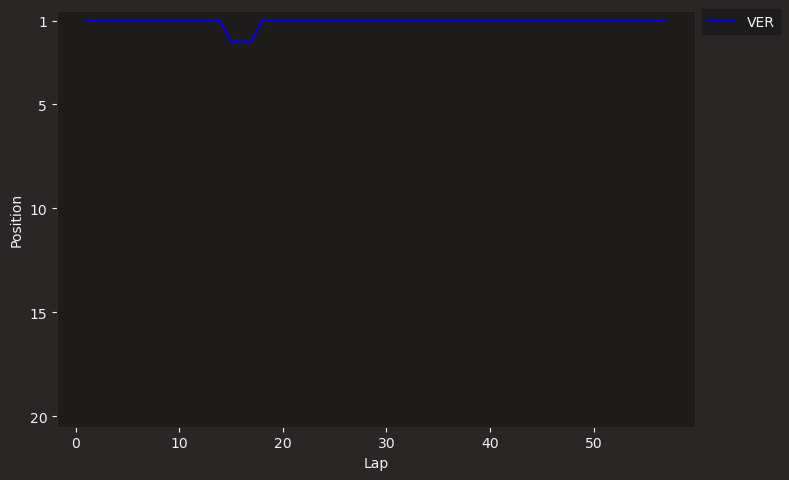

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [1]:
import matplotlib.pyplot as plt
import fastf1.plotting
# Load FastF1's dark color scheme
fastf1.plotting.setup_mpl(mpl_timedelta_support=False, misc_mpl_mods=False,color_scheme='fastf1')
session = fastf1.get_session(2023, 1, 'R')
session.load(telemetry=False, weather=False)
fig, ax = plt.subplots(figsize=(8.0, 4.9))
for drv in session.drivers:
    drv_laps = session.laps.pick_driver(drv)
    abb = drv_laps['Driver'].iloc[0]
    style = fastf1.plotting.get_driver_style(identifier=abb,style=['color', 'linestyle'],session=session)
    ax.plot(drv_laps['LapNumber'], drv_laps['Position'],label=abb, **style)
    ax.set_ylim([20.5, 0.5])
    ax.set_yticks([1, 5, 10, 15, 20])
    ax.set_xlabel('Lap')
    ax.set_ylabel('Position')
    ax.legend(bbox_to_anchor=(1.0, 1.02))
    plt.tight_layout()

    plt.show()